**Import libraries**

In [1]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torch.utils.data
import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.datasets import ImageFolder
from torchvision import datasets

from PIL import Image
from tqdm import tqdm

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import pretrainedmodels
import pickle

**Definitions**

In [2]:
from torch.autograd import Function


class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

**Set Arguments**

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')      # 'cuda' or 'cpu'
    
DATA_DIR = 'PACS\\'  # directory of dataset

NUM_CLASSES = 7    
NUM_DOMAINS = 2    


image_size = 224     # the size required by AlexNet 
BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate

NUM_EPOCHS = 35      # Total number of training epochs (iterations over dataset)

**Define Data Preprocessing**

In [4]:
# Define transforms for training phase    
source_transform = transforms.Compose([
                                      transforms.ColorJitter(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Resize((224, 224)),                             
                                      transforms.ToTensor(),    
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # Normalizes tensor with mean and standard deviation of ImageNet
# Define transforms for the evaluation phase
target_transform = transforms.Compose([
                                     transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])             

**Prepare Dataset**

In [5]:
source_dataset = ImageFolder(DATA_DIR+'photo//', transform=source_transform)
target_dataset = ImageFolder(DATA_DIR+'art_painting//', transform=target_transform)
print('source Dataset: {}'.format(len(source_dataset)))
print('target Dataset: {}'.format(len(target_dataset)))

source Dataset: 1670
target Dataset: 2048


<!-- # xx=Caltech(DATA_DIR, split='train')
# xx.__getitem__(36) -->

**Prepare Dataloaders**

In [6]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
source_dataloader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True)

**Define Network**

In [7]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

__all__ = ['AlexNet', 'alexnet']

model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

class AlexNetDANN(nn.Module):

    def __init__(self, num_classes=1000, num_domains=2):
        super(AlexNetDANN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
                 
        self.class_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
        self.domain_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_domains),
        )

    def forward(self, input_data, alpha):
        input_data = input_data.expand(input_data.data.shape[0], 3, 224, 224)
        feature = self.features(input_data)
        feature = feature.view(feature.size(0), -1)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.class_classifier(feature)
        domain_output = self.domain_classifier(reverse_feature)

        return class_output, domain_output


def alexnetdann(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNetDANN(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict, strict=False)
        r"""
        something of great importace:
        Whether you are loading from a partial state_dict, which is missing some keys, or loading a state_dict with more keys than the model that you are loading into, you can set the strict argument to False in the load_state_dict() function to ignore non-matching keys.
        """
    return model

**Prepare Network Training Functions**

In [8]:
# Define model
my_net = alexnetdann(pretrained=True,progress=True, num_classes=NUM_CLASSES, num_domains=NUM_DOMAINS)

# Define loss function
loss_class = nn.CrossEntropyLoss()
loss_domain = nn.CrossEntropyLoss()

# Choose parameters to optimize
parameters_to_optimize = my_net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
optimizer = optim.SGD(parameters_to_optimize, lr=LR)


#move network to GPU
my_net = my_net.to(device)
loss_class = loss_class.to(device)
loss_domain = loss_domain.to(device)

#to train
for p in my_net.parameters():
    p.requires_grad = True

**Test Function**

In [9]:
def test(dataset_name,epoch):

    batch_size = BATCH_SIZE

    if dataset_name == source_dataloader:
        dataloader = source_dataloader
    else:
        dataloader = target_dataloader    
    
    

    global my_net
    my_net = my_net.to(device)
    my_net = my_net.eval()
    
    len_dataloader = len(dataloader)
    data_target_iter = iter(dataloader)

    i = 0
    n_total = 0
    n_correct = 0

    while i < len_dataloader:
        
        data_target = data_target_iter.next()
        t_img, t_label = data_target

        batch_size = len(t_label)

        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        class_label = torch.LongTensor(batch_size)

        t_img = t_img.to(device)
        t_label = t_label.to(device)
        input_img = input_img.to(device)
        class_label = class_label.to(device)

        input_img.resize_as_(t_img).copy_(t_img)
        class_label.resize_as_(t_label).copy_(t_label)

        class_output, _ = my_net(input_data=input_img, alpha=alpha)
        pred = class_output.data.max(1, keepdim=True)[1]
        n_correct += pred.eq(class_label.data.view_as(pred)).cpu().sum()
        n_total += batch_size

        i += 1

    accu = n_correct.data.numpy() * 1.0 / n_total

    if dataset_name == source_dataloader: 
        print ('epoch: %d, accuracy of the source_dataset: %f' % (epoch+1, accu))
    else:
        print ('epoch: %d, accuracy of the target_dataset: %f' % (epoch+1, accu))
        
    return accu


**Train & Test**

In [10]:
cudnn.benchmark # Calling this optimizes runtime

all_err_s_label=[]
all_err_s_domain=[]
all_err_t_domain=[]
all_acc_source_dataset=[]
all_acc_target_dataset=[]
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    
    it_err_s_label=[]
    it_err_s_domain=[]
    it_err_t_domain=[]

    len_dataloader = min(len(source_dataloader), len(target_dataloader))
    data_source_iter = iter(source_dataloader)
    data_target_iter = iter(target_dataloader)

    i = 0
    while i < len_dataloader:

        p = float(i + epoch * len_dataloader) / NUM_EPOCHS / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # training model using source data
        data_source = data_source_iter.next()
        s_img, s_label = data_source

        my_net.zero_grad()
        my_net.train()
        batch_size = len(s_label)

        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        class_label = torch.LongTensor(batch_size)
        domain_label = torch.zeros(batch_size)
        domain_label = domain_label.long()

        s_img = s_img.to(device)
        s_label = s_label.to(device)
        input_img = input_img.to(device)
        class_label = class_label.to(device)
        domain_label = domain_label.to(device)

        input_img.resize_as_(s_img).copy_(s_img)
        class_label.resize_as_(s_label).copy_(s_label)

        class_output, domain_output = my_net(input_data=input_img, alpha=alpha)
        err_s_label = loss_class(class_output, class_label)
        err_s_domain = loss_domain(domain_output, domain_label)

        # training model using target data
        data_target = data_target_iter.next()
        t_img, _ = data_target

        batch_size = len(t_img)

        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        domain_label = torch.ones(batch_size)
        domain_label = domain_label.long()

        t_img = t_img.to(device)
        input_img = input_img.to(device)
        domain_label = domain_label.to(device)

        input_img.resize_as_(t_img).copy_(t_img)

        _, domain_output = my_net(input_data=input_img, alpha=alpha)
        err_t_domain = loss_domain(domain_output, domain_label)
        err = err_t_domain + err_s_domain + err_s_label
        err.backward()
        optimizer.step()

        i += 1

        print ('epoch: %d, [iter: %d / %d], err_s_label: %f, err_s_domain: %f, err_t_domain: %f' \
              % (epoch+1, i, len_dataloader, err_s_label.data.cpu().numpy(),
                 err_s_domain.data.cpu().numpy(), err_t_domain.data.cpu().item()))
        
        it_err_s_label.append(err_s_label.data.cpu().numpy())
        it_err_s_domain.append(err_s_domain.data.cpu().numpy())
        it_err_t_domain.append(err_t_domain.data.cpu().item())
        
    all_err_s_label.append(min(it_err_s_label))
    all_err_s_domain.append(min(it_err_s_domain))
    all_err_t_domain.append(min(it_err_t_domain))

    all_acc_source_dataset.append(test(source_dataloader,epoch))
    all_acc_target_dataset.append(test(target_dataloader,epoch))

epoch: 1, [iter: 1 / 7], err_s_label: 2.016973, err_s_domain: 0.953112, err_t_domain: 0.519965
epoch: 1, [iter: 2 / 7], err_s_label: 2.006701, err_s_domain: 0.749304, err_t_domain: 0.677271
epoch: 1, [iter: 3 / 7], err_s_label: 1.958613, err_s_domain: 0.702738, err_t_domain: 0.698293
epoch: 1, [iter: 4 / 7], err_s_label: 1.943361, err_s_domain: 0.702946, err_t_domain: 0.705443
epoch: 1, [iter: 5 / 7], err_s_label: 1.888852, err_s_domain: 0.684455, err_t_domain: 0.670706
epoch: 1, [iter: 6 / 7], err_s_label: 1.858400, err_s_domain: 0.695379, err_t_domain: 0.670126
epoch: 1, [iter: 7 / 7], err_s_label: 1.874049, err_s_domain: 0.648646, err_t_domain: 0.661750
epoch: 1, accuracy of the source_dataset: 0.416168
epoch: 1, accuracy of the target_dataset: 0.246582
epoch: 2, [iter: 1 / 7], err_s_label: 1.843632, err_s_domain: 0.671109, err_t_domain: 0.649514
epoch: 2, [iter: 2 / 7], err_s_label: 1.839545, err_s_domain: 0.624539, err_t_domain: 0.647396
epoch: 2, [iter: 3 / 7], err_s_label: 1.806

**Saving & Plotting Results**

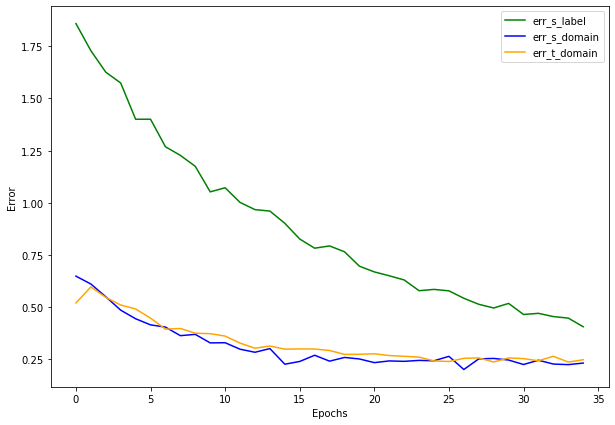

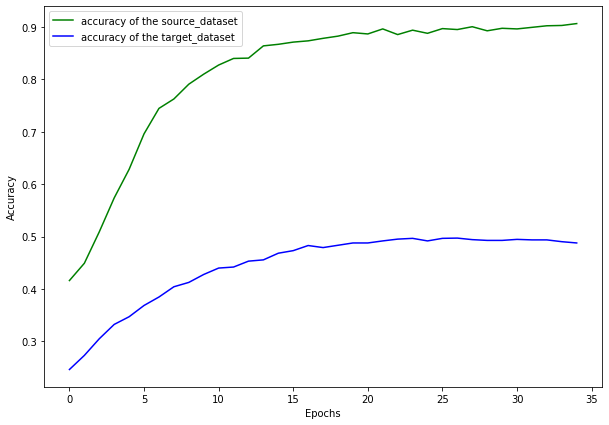

In [11]:
# Error plots
plt.figure(figsize=(10, 7))
plt.plot(all_err_s_label, color='green', label='err_s_label')
plt.plot(all_err_s_domain, color='blue', label='err_s_domain')
plt.plot(all_err_t_domain, color='orange', label='err_t_domain')
    
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.savefig('Errors.png')

# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(all_acc_source_dataset, color='green', label='accuracy of the source_dataset')
plt.plot(all_acc_target_dataset, color='blue', label='accuracy of the target_dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')